Last, we talked about Logistic Regression: P(y|x)

Today, we want to model things in a Generative fashion: P(x,y) = P(x|y)P(y). This is more complex, but we can deal with things like missing data.

To model $P(x,y)$:  
1) Decide on a generative process.  
2) Parametrize the model.  
3) Fit the model by minimizing the negative log likelihood.  

If $y$ is binary, let $P(y)$ be Bernoulli with a parameter $\theta$.

$P(y) = \theta^y (1-\theta)^{1-y}$

By Bayes Rule: 
$p(y=c_k | x) \propto P(x|c_k) P(c_k)$

The choice of $P(x|c_k)$ is informed by your data. Suppose $x$ is continuous, we can assume that each class is modeled by a Gaussian. 

$x \sim N(\mu_1, \Sigma_1)$ for $c_1$  
$x \sim N(\mu_2, \Sigma_2)$ for $c_2$

We can then use $\log \frac{P(c_1 | x)}{P(c_2 | x)} > 0$ as the decision boundary.

In [ ]:
# Imports.
import numpy as np
import scipy as sp
from scipy.special import logsumexp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as c
import seaborn as sns
from sklearn.datasets import load_iris

In [ ]:
# Load some toy data.
df_X, df_Y = load_iris(return_X_y=True, as_frame=True)  
print(df_X.shape, df_Y.shape)

(150, 4) (150,)


In [ ]:
# Combine X and Y into a single Pandas dataframe. 
data = pd.concat([df_X,df_Y], axis=1)
data.head(7)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
5,5.4,3.9,1.7,0.4,0
6,4.6,3.4,1.4,0.3,0


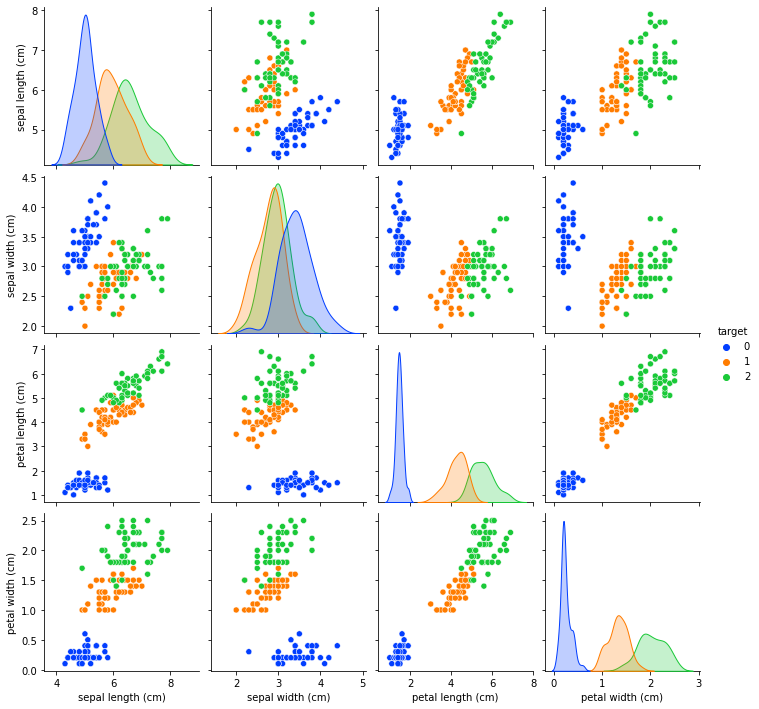

In [ ]:
# Plot the data.
sns.pairplot(data, hue='target', palette='bright')  # kind='kde'

In [ ]:
# Format the input data.
x0 = np.ones(data.shape[0])
x1 = data['petal length (cm)'].values 
x2 = data['petal width (cm)'].values
X = np.vstack([x1, x2]).T  # Ignore x0 for now. 

# Output data.
y = data['target'].values 

# Check shapes.
print(X.shape, y.shape)

(150, 2) (150,)


In [ ]:
# Let's fit a generative classifier, where the prior over class assignments is uniform (so we can ignore it). 
# We model each class as being generated by a multivariate Gaussian distribution. 
# A multivariate Gaussian is parametrized by a mean and covarance. 
# We choose to have a separate covariance for each class. Covariances could be shared to have less parameters to learn (see Bishop). 

# Let's estimate the means.
mean_c0 = np.mean(X[y==0], axis=0)
mean_c1 = np.mean(X[y==1], axis=0)
mean_c2 = np.mean(X[y==2], axis=0)

# Let's estimate the covariances.
cov_c0 = np.cov(X[y==0], rowvar=False)  # rowvar=False defines the columns as the variables
cov_c1 = np.cov(X[y==1], rowvar=False)
cov_c2 = np.cov(X[y==2], rowvar=False)

# Let's define the PDFs of each class Gaussian.
pdf_c0 = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_c0, cov=cov_c0)
pdf_c1 = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_c1, cov=cov_c1)
pdf_c2 = lambda x: sp.stats.multivariate_normal.pdf(x, mean=mean_c2, cov=cov_c2)

In [1]:
# Can plot the learned decision boundaries.
grid_x = np.arange(0,7.5,0.05)
grid_y = np.arange(0,3,0.05)
grid = np.zeros((len(grid_x), len(grid_y)))
for ix, ex in enumerate(grid_x):
    for iy, ey in enumerate(grid_y):
        grid[ix, iy] = np.argmax([pdf_c0([ex,ey]), pdf_c1([ex,ey]), pdf_c2([ex,ey])])  # Predictions.

NameError: ignored

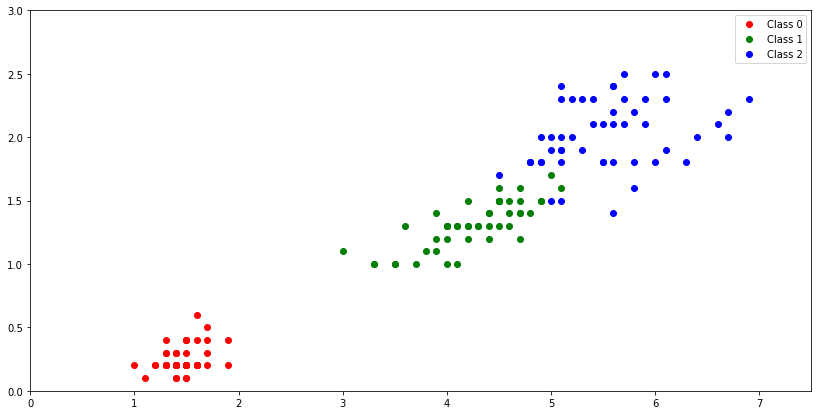

In [ ]:
# Plot data.
plt.figure(figsize=(14,7))
plt.plot(X[y==0,0], X[y==0,1], 'ro', label='Class 0')
plt.plot(X[y==1,0], X[y==1,1], 'go', label='Class 1')
plt.plot(X[y==2,0], X[y==2,1], 'bo', label='Class 2')
plt.xlim([0,7.5])
plt.ylim([0,3])
plt.legend()

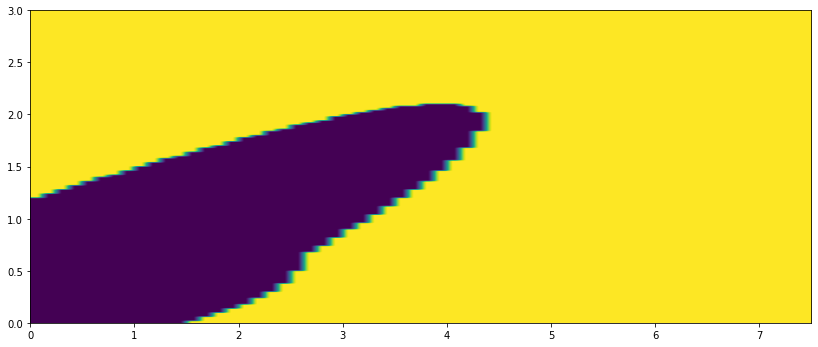

In [ ]:
# Can plot the learned decision boundaries.
plt.figure(figsize=(14,7))
plt.imshow(np.flip(grid,0)==2, extent=(0,7.5,0,3))  # flip is needed as imshow plots in image coordinates
#plt.colorbar()

In [ ]:
# Next, let's look at logistic regression.
# Let's write a class that broadly follows the sklearn interface. 
class LogisticRegression:
    def __init__(self, eta, lambda_parameter):
        self.eta = eta
        self.lambda_parameter = lambda_parameter

    # Numerically stable calculation of log softmax
    # Uses the property that log(softmax(z)) = z - log(sum(exp(z)))
    def __log_softmax(self, X, W):
        res = X.dot(W.T)
        lse = logsumexp(res, axis=1)[:, np.newaxis]
        return res - lse

    def __makeOneHot(self, i):
        onehot = np.zeros(self.nClasses)
        onehot[i] = 1
        return onehot

    def __makeAllOneHot(self, Y):
        return np.array([self.__makeOneHot(y) for y in Y])

    # Note that this is calculating the gradient over the whole training set
    # Assumes that Y is given as a one-hot vector.
    # Also adds regularization, 'lambda' is a reserved keyword in python.

    # Step 1: Write down the likelihood equation (3.15).
    # Step 2: Take the negative log (3.16).
    # Step 3: Compute the gradient (3.17).
    def __gradient(self):  # Equation (3.17).
        log_softmax_result = self.__log_softmax(self.X, self.W)
        softmax_result = np.exp(log_softmax_result)
        diff = softmax_result - self.Y
        W_grad  =  diff.T.dot(self.X)
        return W_grad + 2 * self.lambda_parameter * self.W

    def __updateParameters(self):
        W_grad = self.__gradient()
        self.W = self.W - W_grad * self.eta
        return W_grad

    def __loss(self):
        total_loss = 0.
        log_softmax_res = self.__log_softmax(self.X, self.W)
        total_loss = -np.sum(self.Y * log_softmax_res)
        # Add regularization.
        return total_loss + self.lambda_parameter * (np.power(self.W, 2).sum())


    def fit(self, X, Y):
        assert(X.shape[0] == Y.shape[0])

        # Add a column of 1s
        X = np.append(X, np.ones((X.shape[0], 1)), axis=1)

        nClasses = max(Y) + 1
        nFeatures = X.shape[1]
        N = X.shape[0]
        self.nClasses = nClasses
        self.nFeatures = nFeatures
        self.X = X
        self.C = Y
        self.Y = self.__makeAllOneHot(Y)
        self.N = N
        self.W = np.zeros((nClasses, nFeatures))

        print(self.__loss())
        epoch = 0
        while True:
            epoch += 1
            # Update the gradient
            gradient = self.__updateParameters()

            # Every 100000 times, also calculate the gradient norm and loss, and
            # display it.
            if epoch % 100000 == 0:
                norm = np.linalg.norm(gradient)
                loss = self.__loss()
                print("On epoch: {}".format(epoch))
                print("   Gradient norm is {}".format(norm))
                print("   Loss is {}".format(loss))
                #print(self.W)
                if norm < .000001:
                    break

    def predict(self, X_to_predict): # Often in sklearn, you will see predict and predict_proba.
        X_to_predict = np.append(X_to_predict, np.ones((X_to_predict.shape[0],
                                                        1)), axis=1)
        softmax_res = X_to_predict.dot(self.W.T)
        predictions = np.argmax(softmax_res, axis=1)
        print(np.bincount(predictions))
        return predictions

    def visualize(self, width=2):
        X = self.X

        # Create a grid of points
        x_min, x_max = min(X[:, 0] - width), max(X[:, 0] + width)
        y_min, y_max = min(X[:, 1] - width), max(X[:, 1] + width)
        xx,yy = np.meshgrid(np.arange(x_min, x_max, .05), np.arange(y_min,
            y_max, .05))

        # Flatten the grid so the values match spec for self.predict
        xx_flat = xx.flatten()
        yy_flat = yy.flatten()
        X_topredict = np.vstack((xx_flat,yy_flat)).T

        # Get the class predictions
        Y_hat = self.predict(X_topredict)
        Y_hat = Y_hat.reshape((xx.shape[0], xx.shape[1]))
        
        cMap = c.ListedColormap(['r','g','b'])

        # Visualize them.
        plt.figure()
        plt.pcolormesh(xx,yy,Y_hat, cmap=cMap, alpha=0.1)
        plt.scatter(X[:, 0], X[:, 1], c=self.C, cmap=cMap)
        plt.show()

164.79184330021644
On epoch: 100000
   Gradient norm is 0.019595232372010246
   Loss is 42.14730879809305
On epoch: 200000
   Gradient norm is 0.0003291587214706114
   Loss is 42.14691247822536
On epoch: 300000
   Gradient norm is 2.2213801150686426e-05
   Loss is 42.14691228650968
On epoch: 400000
   Gradient norm is 1.6167372401205484e-06
   Loss is 42.14691228557347
On epoch: 500000
   Gradient norm is 1.1774431583286966e-07
   Loss is 42.14691228556851
[ 7109  7563 10672]


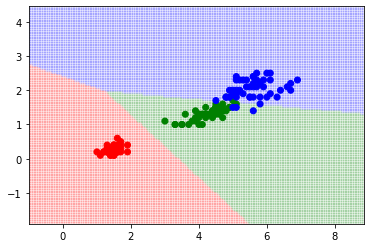

In [ ]:
eta = 0.0001
lambda_parameter = 0.1
lr = LogisticRegression(eta=eta, lambda_parameter=lambda_parameter)
lr.fit(X,y)
lr.visualize()